# Type 1 transition 

In [24]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue import Sheet, Monolayer, config
from tyssue import SheetGeometry as geom

# What we're here for
from tyssue.topology.sheet_topology import type1_transition
from tyssue.topology.base_topology import collapse_edge, remove_face
from tyssue.topology.sheet_topology import split_vert as sheet_split
from tyssue.topology.bulk_topology import split_vert as bulk_split
from tyssue.topology import condition_4i, condition_4ii

## model and solver
from tyssue.dynamics.sheet_vertex_model import SheetModel as model
from tyssue.solvers.quasistatic import QSSolver
from tyssue.generation import extrude
from tyssue.dynamics import model_factory, effectors

# 2D plotting
from tyssue.draw import sheet_view, highlight_cells

#I/O
from tyssue.io import hdf5
plt.style.use('bmh')

import logging


import numpy as np
import pandas as pd
import ipyvolume as ipv

import matplotlib.pylab as plt
%matplotlib inline


![Type 1 transition](illus/t1_transition.png)

Reseting column contractility of the face dataset with new specs
Reseting column vol_elasticity of the face dataset with new specs
Reseting column prefered_height of the face dataset with new specs
Reseting column prefered_area of the face dataset with new specs
Reseting column prefered_vol of the face dataset with new specs
Reseting column radial_tension of the vert dataset with new specs
Reseting column is_active of the vert dataset with new specs
Reseting column ux of the edge dataset with new specs
Reseting column uy of the edge dataset with new specs
Reseting column uz of the edge dataset with new specs
Reseting column line_tension of the edge dataset with new specs
Reseting column is_active of the edge dataset with new specs


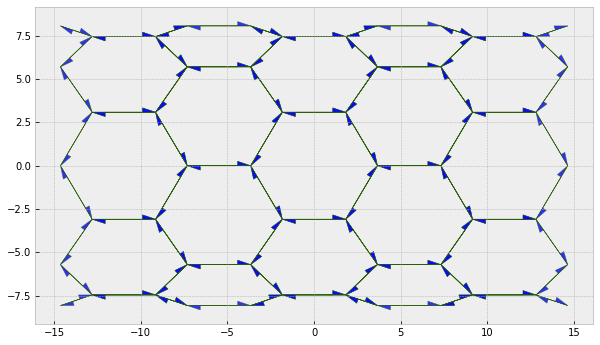

In [2]:
solver = QSSolver()

h5store = 'data/small_hexagonal.hf5'
datasets = hdf5.load_datasets(h5store,
                              data_names=['face', 'vert', 'edge'])
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)


geom.update_all(sheet)

nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimensionalize(nondim_specs)
sheet.update_specs(dim_model_specs, reset=True)

solver_settings = {'options': {'gtol':1e-4}}

sheet.get_opposite()
sheet.vert_df.is_active = 0

active_edges = (sheet.edge_df['opposite'] > -1)
active_verts = set(sheet.edge_df[active_edges]['srce'])

sheet.vert_df.loc[active_verts, 'is_active'] = 1

fig, ax = sheet_view(sheet, ['z', 'x'],
                     edge={'head_width': 0.5},
                     vert={'visible': False})
fig.set_size_inches(10, 6)


In [3]:
type1_transition(sheet, 82)
geom.update_all(sheet)


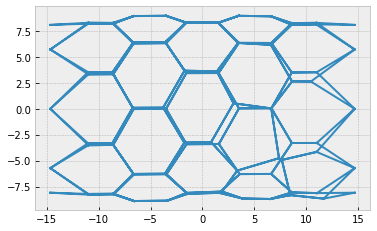

In [4]:
res = solver.find_energy_min(sheet, geom, model, **solver_settings)
fig, ax = sheet_view(sheet, mode="quick", coords=['z', 'x'])


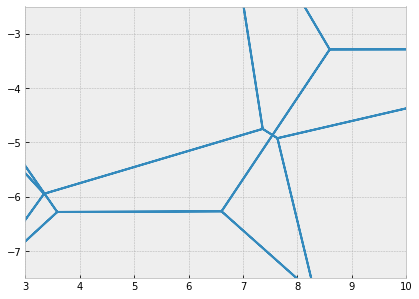

In [5]:

fig, ax = sheet_view(sheet, ['z', 'x'], mode="quick")

ax.set_xlim(3, 10)
ax.set_ylim(-7.5, -2.5)

ax.set_aspect('equal')
fig.set_size_inches(8, 5)


In [6]:
fig, mesh = sheet_view(sheet, mode='3D')
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

True


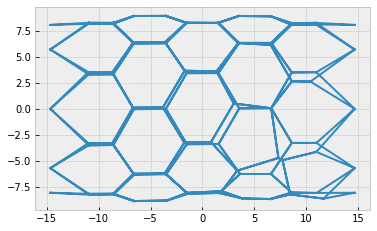

In [8]:
res = solver.find_energy_min(sheet, geom, model)
print(res['success'])
fig, ax = sheet_view(sheet, ['z', 'x'], mode="quick")


In [9]:
sheet.validate()

True

#### Type 1 transitions can also be performed on border faces

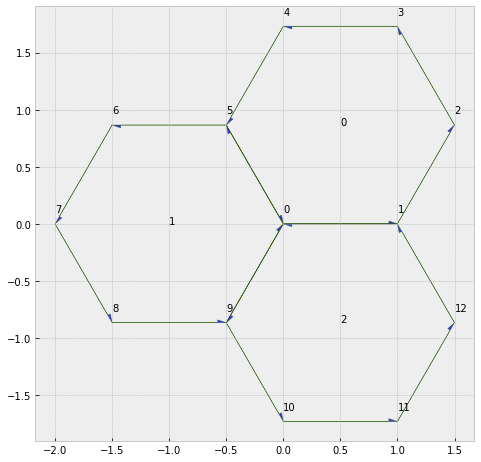

In [10]:
from tyssue.generation import three_faces_sheet

sheet = Sheet('3f', *three_faces_sheet())
geom.update_all(sheet)
fig, ax = sheet_view(sheet, edge={'head_width': 0.05})
fig.set_size_inches(8, 8)

for face, data in sheet.face_df.iterrows():
    ax.text(data.x, data.y, face)
for vert, data in sheet.vert_df.iterrows():
    ax.text(data.x, data.y+0.1, vert)



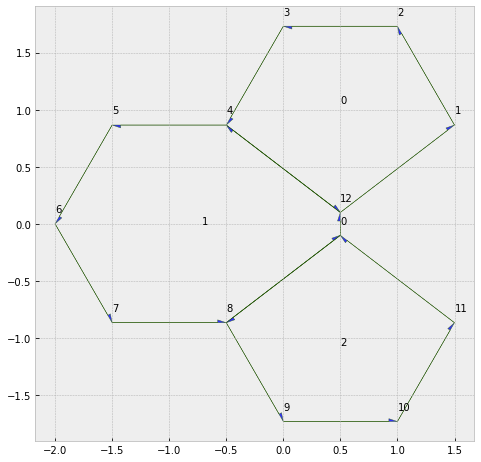

In [11]:

type1_transition(sheet, 0, multiplier=2)
sheet.reset_index()

geom.update_all(sheet)

fig, ax = sheet_view(sheet, edge={'head_width': 0.05})
fig.set_size_inches(8, 8)
for face, data in sheet.face_df.iterrows():
    ax.text(data.x, data.y, face)

for vert, data in sheet.vert_df.iterrows():
    ax.text(data.x, data.y+0.1, vert)

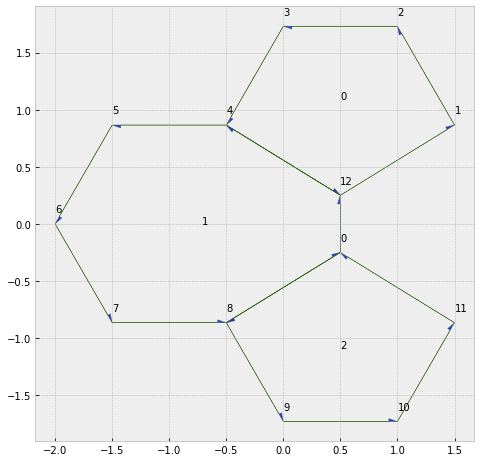

In [14]:
type1_transition(sheet, 16, multiplier=5)

geom.update_all(sheet)

fig, ax = sheet_view(sheet, edge={'head_width': 0.05})
fig.set_size_inches(8, 8)
for face, data in sheet.face_df.iterrows():
    ax.text(data.x, data.y, face)

for vert, data in sheet.vert_df.iterrows():
    ax.text(data.x, data.y+0.1, vert)

In [15]:
sheet.validate()

True

True


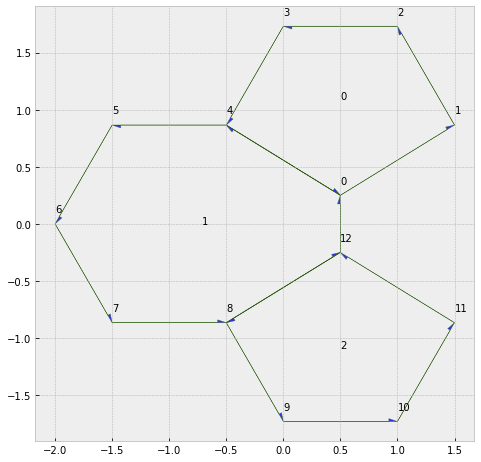

In [18]:
type1_transition(sheet, 17,  multiplier=5)

geom.update_all(sheet)
print(sheet.validate())

fig, ax = sheet_view(sheet, edge={'head_width': 0.05})
fig.set_size_inches(8, 8)
for face, data in sheet.face_df.iterrows():
    ax.text(data.x, data.y, face)

for vert, data in sheet.vert_df.iterrows():
    ax.text(data.x, data.y+0.1, vert)

# Rosette

This part is based on the following paper:

>**The tricellular vertex-specific adhesion molecule Sidekick facilitates polarised cell intercalation during Drosophila axis extension** _Tara M Finegan, Nathan Hervieux, Alexander Nestor-Bergmann, Alexander G. Fletcher, Guy B Blanchard, Benedicte Sanson_ bioRxiv 704932; doi: https://doi.org/10.1101/704932 

In particular, the authors expose a nice way to account for rosettes and solve topology changes in a more generic and I think robust way than T1 transition. I think, it allows vertices with more than 3 out-edges to have a finite lifetime, and avoids T1 oscillations



I explore its implementation in [tyssue](https://github.com/damcb/tyssue), in 2D (also maybe in 3D, though it's less clear how :p).

In [25]:
from tyssue import PlanarGeometry as geom

### Create a small patch of cells in 2D and a simple mechanical model

In [26]:
sheet = Sheet.planar_sheet_2d('flat', 30, 30, 1, 1, noise=0.2)
to_cut = sheet.cut_out([(0.1, 6), (0.1, 6)])
sheet.remove(to_cut, trim_borders=True)
sheet.sanitize(trim_borders=True)
geom.center(sheet)
geom.update_all(sheet)
sheet.update_rank()
model = model_factory(
    [
        effectors.LineTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity
    ]
)

specs = {
    "face": {
        "contractility": 5e-2,
        "prefered_area": sheet.face_df.area.mean(),
        "area_elasticity": 1.
    },
    "edge": {
        "line_tension": 1e-2,
        "is_active": 1
    },
    "vert": {
        "is_active": 1
    },
}

sheet.update_specs(specs, reset=True)

Reseting column is_active of the vert dataset with new specs


### Gradient descent

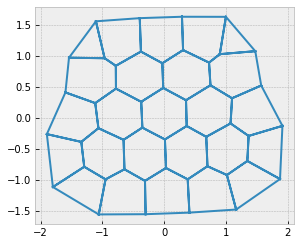

In [27]:
solver = QSSolver()

res = solver.find_energy_min(sheet, geom, model)

fig, ax = sheet_view(sheet, mode="quick")


## Formation of rosettes

<hr/>

![first screencap, forming rosettes](illus/finegan_etal_screencap1.png)

_Finegan et al. 2019_

### Merge vertices

Or, said otherwise, collapse an edge

Maximum vertex rank:  4


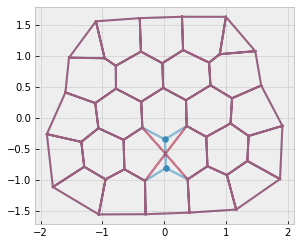

In [28]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})
center_edge = sheet.edge_df.eval("sx**2 + sy**2").idxmin()
ax.scatter(sheet.edge_df.loc[center_edge, ["sx", "tx"]],
           sheet.edge_df.loc[center_edge, ["sy", "ty"]])

collapse_edge(sheet, center_edge)
sheet.update_rank()

geom.update_all(sheet)
fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})

print("Maximum vertex rank: ", sheet.vert_df['rank'].max())

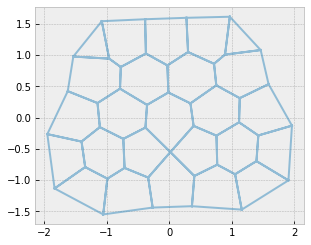

In [29]:
res = solver.find_energy_min(sheet, geom, model)
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})


### Do it again to increase rank

Maximum vertex rank:  4


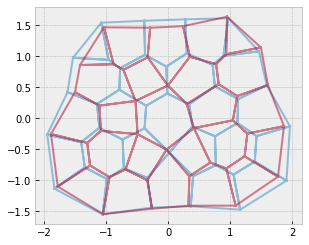

In [30]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

for i in range(4):
    center_edge = sheet.edge_df.eval("sx**2 + sy**2").idxmin()
    collapse_edge(sheet, center_edge)
    geom.update_all(sheet)
    res = solver.find_energy_min(sheet, geom, model)
    sheet.update_rank()

fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})


print("Maximum vertex rank: ", sheet.vert_df['rank'].max())

## Rosettes resolution

<hr/>

![Second screencap, solving rosettes](illus/finegan_etal_screencap2.png)

_Finegan et al. 2019_



As far as I understand, the difference between rank 5+ and rank 4 is not topological, but geometrical (the "old" vertex is moved towards the opposite cell center) and statistical because $p_4$ is higher than $p_{5+}$

### Solve for a single edge

Maximum vertex rank prior to rearangement:  4
Maximum vertex rank after rearangement:  4


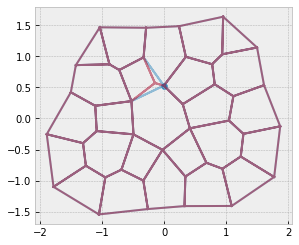

In [31]:
#sheet = bck.copy()
max_rank = sheet.vert_df['rank'].idxmax()

print("Maximum vertex rank prior to rearangement: ", sheet.vert_df['rank'].max())


fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})
max_rank_vert = sheet.vert_df['rank'].idxmax()

ax.scatter(sheet.vert_df.loc[max_rank_vert, "x"],
           sheet.vert_df.loc[max_rank_vert, "y"])

sheet_split(sheet, max_rank_vert)
sheet.update_rank()

geom.update_all(sheet)
fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})

print("Maximum vertex rank after rearangement: ", sheet.vert_df['rank'].max())


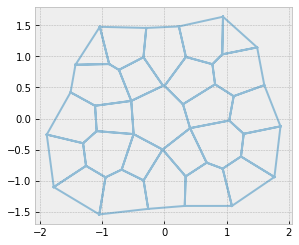

In [32]:
res = solver.find_energy_min(sheet, geom, model)
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

### Solve repeatedly

Maximum vertex rank prior to rearangement:  4
Maximum vertex rank:  4
Maximum vertex rank:  4
Maximum vertex rank:  4
Maximum vertex rank:  3


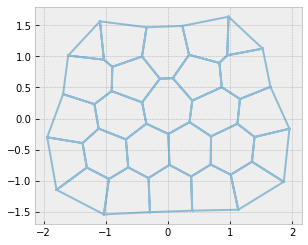

In [33]:
#sheet = bck.copy()
max_rank = sheet.vert_df['rank'].max()
print("Maximum vertex rank prior to rearangement: ", max_rank)

while max_rank > 3:
    max_rank_vert = sheet.vert_df['rank'].idxmax()

    sheet_split(sheet, max_rank_vert)
    sheet.update_rank()

    geom.update_all(sheet)

    res = solver.find_energy_min(sheet, geom, model)
    max_rank = sheet.vert_df['rank'].max()

    print("Maximum vertex rank: ", max_rank)

fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

In [34]:
assert sheet.validate()

#### Collapse a face and resolve the rosette

In [35]:
remove_face(sheet, 12)
sheet.update_rank()
geom.update_all(sheet)

res = solver.find_energy_min(sheet, geom, model)

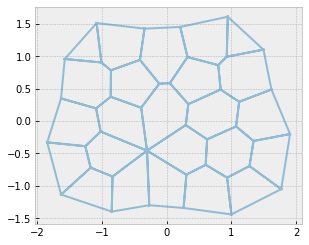

In [36]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})


In [37]:
max_rank = sheet.vert_df['rank'].max()
while max_rank > 3:
    max_rank_vert = sheet.vert_df['rank'].idxmax()

    sheet_split(sheet, max_rank_vert)
    sheet.update_rank()

    geom.update_all(sheet)

    res = solver.find_energy_min(sheet, geom, model)
    max_rank = sheet.vert_df['rank'].max()

    print("Maximum vertex rank: ", max_rank)

Maximum vertex rank:  5
Maximum vertex rank:  4
Maximum vertex rank:  3


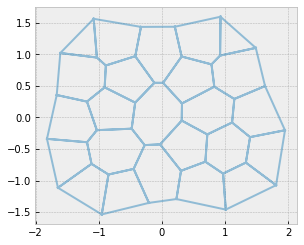

In [38]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

# How about in 3D?



### Illustration of the split / collapse algorithm in 3D


![illustration of the rearangements](illus/IH_transition.png)

### Extrude a monolayer from the previous sheet

In [39]:
from tyssue import MonolayerGeometry as geom

# Promote the sheet to 2.5 D
sheet.update_specs(config.geometry.sheet_spec())


specs = config.geometry.bulk_spec()
datasets = extrude(sheet.datasets, method='translation')
eptm = Monolayer('mono', datasets, specs)

geom.center(eptm)
geom.update_all(eptm) 

## Sanity check
assert eptm.validate()

### Setup a simple mechanical model and quasistatically descend it

In [40]:
model = model_factory([
    effectors.CellVolumeElasticity,
    effectors.FaceContractility,
    effectors.LineTension,
])

## Initial model settings
dyn_specs = {
    "settings": {
        "threshold_length": 1e-3,
    },
    "cell": {
        "prefered_vol": eptm.cell_df.vol.mean(),
        "prefered_area": eptm.cell_df.area.mean(),
        "vol_elasticity": 14.0,
        #"area_elasticity": 1.0,
    },
    "face": {
        #"surface_tension": 1.0,
        "contractility": 1e-2
    },
    "edge": {
        "line_tension": 0.01,
    }
}

## Those settings are set homogenously in the epithelium
eptm.update_specs(dyn_specs, reset=True)

# Lower the lateral contractility
eptm.face_df.loc[eptm.lateral_faces, 'contractility'] /= 2

solver = QSSolver(with_t1=False, with_t3=False)
res = solver.find_energy_min(eptm, geom, model)
eptm.update_rank()

ipv.clear()
eptm.face_df["visible"] =True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

Reseting column contractility of the face dataset with new specs
Reseting column line_tension of the edge dataset with new specs


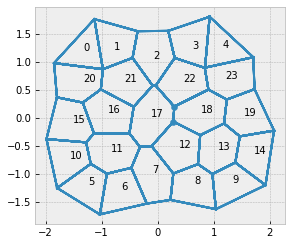

In [41]:
center_edge = eptm.edge_df.query('segment == "apical"').eval("sx**2 + sy**2").idxmin()

fig, ax = sheet_view(eptm, coords = ['x', 'y'], mode="quick")
for cell, (x, y) in eptm.cell_df[['x', 'y']].iterrows():
    ax.text(x, y, str(cell))
_= ax.scatter(
    eptm.edge_df.loc[center_edge, ['sx', 'tx']],
    eptm.edge_df.loc[center_edge, ['sy', 'ty']])


In [42]:
ret_code = collapse_edge(eptm, center_edge, allow_two_sided=True)
if ret_code:
    print('Collapse failed')
geom.update_all(eptm)

eptm.update_rank()
print("Maximum vertex rank: ", eptm.vert_df['rank'].max())

ipv.clear()
eptm.face_df["visible"] = eptm.face_df['segment'] == "lateral"
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

assert eptm.validate()


print("Maximum vertex rank: ", eptm.vert_df['rank'].max())
vert = eptm.vert_df['rank'].idxmax()
print("Rosette index: ", vert)
bck = eptm.copy()


Maximum vertex rank:  6


Maximum vertex rank:  6
Rosette index:  31


In [43]:
set(condition_4ii(eptm).ravel())

set()

In [44]:
res = solver.find_energy_min(eptm, geom, model)


In [45]:

eptm.settings['threshold_length'] = 0.1
bulk_split(eptm, vert, face=None, multiplier=2)

assert eptm.validate()

cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


In [46]:
ipv.clear()
geom.update_all(eptm)
res = solver.find_energy_min(eptm, geom, model)

eptm.face_df["visible"] = False
#eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False
c4ii = np.unique(condition_4ii(eptm))
eptm.face_df.loc[c4ii, "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

/home/admin-suz/miniconda3/lib/python3.8/site-packages/tyssue-0.8.1-py3.8-linux-x86_64.egg/tyssue/utils/utils.py:161: UserWarning: Sub epithelium appears to be empty
  warnings.warn("Sub epithelium appears to be empty")


## Testing vertex split towards all possible faces

In [47]:
all_edges = bck.edge_df[
    (bck.edge_df["trgt"] == vert)
    | (bck.edge_df["srce"] == vert)
]


eptms = {}
for face, edge in all_edges.reset_index().groupby("face").first()['edge'].items():
    eptm = bck.copy()
    cell = eptm.edge_df.loc[edge, "cell"]
    print(f"splitting vertex {vert} towards cell {cell} over face {face}")
    bulk_split(eptm, vert, face=face, multiplier=2)
    assert eptm.validate()
    c4i, c4ii = condition_4i(eptm), condition_4ii(eptm)
    if len(c4i):
        print(f"\nIssue with face {face}")
        print("Number of condition 4i faces : ", len(c4i))
    if len(c4ii):
        print(f"\nIssue with face {face}")
        print("Number of condition 4ii faces : ", len(c4ii))
    
    eptms[face] = eptm


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 12 over face 12
splitting vertex 31 towards cell 17 over face 17


cell 18 is already closed
cell 17 is already closed
cell 18 is already closed


splitting vertex 31 towards cell 18 over face 18


cell 17 is already closed


splitting vertex 31 towards cell 22 over face 22


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed
cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 18 over face 107


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 22 over face 108


cell 18 is already closed


splitting vertex 31 towards cell 18 over face 111


cell 17 is already closed


splitting vertex 31 towards cell 17 over face 112


cell 18 is already closed
cell 17 is already closed
cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 17 over face 117


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 22 over face 118


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 12 over face 119


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 17 over face 120


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 12 over face 160


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 18 over face 161


In [48]:
ipv.clear()
geom.update_all(eptm)

eptm.face_df["visible"] = False
#eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

/home/admin-suz/miniconda3/lib/python3.8/site-packages/tyssue-0.8.1-py3.8-linux-x86_64.egg/tyssue/utils/utils.py:161: UserWarning: Sub epithelium appears to be empty
  warnings.warn("Sub epithelium appears to be empty")


### Collapsing a face

In [49]:
eptm.vert_df['rank'].min()

4

In [50]:
condition_4ii(eptm)

array([], shape=(0, 2), dtype=int64)

In [51]:
center_face = eptm.face_df.query("segment == 'apical'").eval("x**2 + y**2").idxmin()

remove_face(eptm, center_face)

0

In [52]:
ipv.clear()
geom.update_all(eptm)
res = solver.find_energy_min(eptm, geom, model)

#eptm.face_df["visible"] = False
eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

### Split the created vertex

In [53]:
vert = eptm.vert_df.index[-1]

bulk_split(eptm, vert)


geom.update_all(eptm)

assert eptm.validate()

cell 2 is already closed
cell 7 is already closed
cell 12 is already closed
cell 18 is already closed
cell 11 is already closed
cell 16 is already closed
cell 17 is already closed


In [54]:
ipv.clear()
geom.update_all(eptm)
res = solver.find_energy_min(eptm, geom, model)

#eptm.face_df["visible"] = False
eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

In [55]:
eptm.update_rank()

print("Maximum vertex rank: ", eptm.vert_df['rank'].max())

vert = eptm.vert_df['rank'].idxmax()
print("Rosette index: ", vert)

Maximum vertex rank:  14
Rosette index:  84


### Solve repeatedly

In [56]:
from itertools import count

In [57]:
for i in count():
    vert = eptm.vert_df['rank'].idxmax()
    try:
        bulk_split(eptm, vert)
    except ValueError:
        continue
    eptm.update_rank()
    max_rank = eptm.vert_df['rank'].max()
    print("Maximum vertex rank: ", max_rank)
    
    geom.update_all(eptm)
    res = solver.find_energy_min(eptm, geom, model)
    assert eptm.validate()
    if max_rank < 5:
        break
    
    elif i > 100:
        raise RecursionError
    

cell 7 is already closed
cell 18 is already closed
cell 22 is already closed
cell 16 is already closed
cell 21 is already closed
cell 17 is already closed


Maximum vertex rank:  12


cell 22 is already closed
cell 16 is already closed
cell 12 is already closed
cell 21 is already closed
cell 17 is already closed


Maximum vertex rank:  10


cell 18 is already closed
cell 22 is already closed
cell 11 is already closed
cell 16 is already closed
cell 21 is already closed


Maximum vertex rank:  8


cell 18 is already closed
cell 22 is already closed
cell 11 is already closed
cell 16 is already closed
cell 17 is already closed


Maximum vertex rank:  6


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 11 is already closed


Maximum vertex rank:  4


In [58]:
ipv.clear()
geom.update_all(eptm)

#eptm.face_df["visible"] = False
eptm.face_df["visible"] = True #eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()